# Predicting Enron Spam Emails using Supervised Learning

## DS-GA 1001: Introduction to Data Science Final Project

### Scripts

## Models

## Random Forest

## Gradient Boosting Machine

Created On: 11/30/2020

Modified On: 12/04/2020

### Description

This script establishes various supervised learning models for the `emails_cleaned.csv` dataset.

### Data

We applied feature engineering to make the data ready for models.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

print("SUCCESS! All modules have been imported.")

SUCCESS! All modules have been imported.


In [25]:
df = pd.read_csv('../data/emails_cleaned.csv')

In [26]:
# Remove rows containing missing values
df.dropna(subset=['X'], inplace=True)
# Confirm that there is no missing values
df.isnull().sum()

X    0
y    0
dtype: int64

In [27]:
df.shape
print('The model-ready dataset contains {} rows.'.format(df.shape[0]))

The model-ready dataset contains 785672 rows.


### Feature Engineering

We applied [Term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (TF-IDF) method to transform string email contents into meaningful numeric figures so that they can be applied for model training.

#### TF-IDF

In [28]:
# Create a vectorization matrix using tf-idf vectorizer
vectorizer = TfidfVectorizer()
vectorized_emails = vectorizer.fit_transform(df.X)
vectorized_emails

<785672x143171 sparse matrix of type '<class 'numpy.float64'>'
	with 4293210 stored elements in Compressed Sparse Row format>

### Methods

#### Train Test Split

Before fitting the model, we splitted the dataset into two parts: train set and test set. We used train set to train models and used test set to examine the performance of each model.

In [37]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(vectorized_emails, df.y, test_size=test_size, random_state=88)

#### Cross Validation

We applied cross validation to improve model performance.

#### Grid Search

We also applied grid search with to tune the hyperparameters. The goal is to find the optimal hyperparameter `C` so that our model will reach the optimal complexity. 

### Logstic Regression with Elastic Net (Baseline)

We used logistic regression as our baseline model. We also applied elastic net to weight coefficients and added a penalty term to our model. 

##### Elastic Net

We first applied grid search on the parameter of the elastic net, `l1 ratio`. We created a hyperparameter space that contains 30 possible l1 ratio values. We then fitted the training data with 5-fold cross validation to get the best l1 ratio. 

In [16]:
# Setup a hyperparameter grid for l1_ratio that is from 0 to 1
l1_space = [0.2, 0.5, 0.8]
param_grid = {'l1_ratio': l1_space}

In [18]:
elastic_net = ElasticNet()

In [19]:
# Setup the grid search and fit the training data
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, n_jobs=-1)
gm_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'l1_ratio': [0.2, 0.5, 0.8]})

In [20]:
# Predict on the test dataset and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.2}
Tuned ElasticNet R squared: -9.747972842921726e-06
Tuned ElasticNet MSE: 0.2497127785371497


#### Regularization Strength

We also considered tuning the regularization parameter, `C`. A large `C` leads to overfit while a small `C` can get to underfit. In this case, we set the parameter to 1.

In [13]:
# Setup a hyperparameter grid for C that is from 0 to 1
# param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

In [14]:
# Fit a logistic regression model with elastic net and built-in cross validation
logreg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=5000, verbose=0.2)

In [ ]:
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
logreg.fit(X_train, y_train)

In [ ]:
# best_params_logreg = logreg_cv.best_params_
# validation_auc_logreg = logreg_cv.best_score_
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
test_auc_logreg = roc_auc_score(y_test, y_pred_prob)
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_prob)

In [ ]:
# logreg_cv.best_estimator_

In [ ]:
print('Tuned Logstic Regression Test AUC: {}'.format(test_auc_logreg))

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=300, tight_layout=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logreg, tpr_logreg)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Logistic Regression')
plt.show()
fig.savefig('../results/roc_curve_logistic_regression.png', dpi=fig.dpi)

### Random Forest

In [31]:
#Setup a hyperparamter grid for random forest
n_estimators = [100]
max_depth = [200]
min_samples_leaf = [10]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

In [32]:
rf = RandomForestClassifier(criterion='entropy', random_state=88, verbose=0.1)

In [33]:
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=88,
                                              verbose=0, warm_start=False),
             iid=

In [74]:
best_param_rf = rf_cv.best_params_
validation_auc_rf = rf_cv.best_score_
y_pred = rf_cv.predict(X_test)
y_pred_prob = rf_cv.predict_proba(X_test)[:, 1]
test_auc_rf = roc_auc_score(y_test, y_pred_prob)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob)

In [75]:
rf_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=200, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [76]:
print('Tuned Random Forest Parameters: {}'.format(best_param_rf))
print('Tuned Random Forest Validation AUC: {}'.format(validation_auc_rf))
print('Tuned Random Forest Test AUC: {}'.format(test_auc_rf))

Tuned Random Forest Parameters: {'max_depth': 200, 'min_samples_leaf': 10, 'n_estimators': 100}
Tuned Random Forest Validation AUC: 0.8915474294798399
Tuned Random Forest Test AUC: 0.8932277809035443


In [77]:
print(confusion_matrix(y_test, y_pred))

[[57224 24139]
 [ 7825 67947]]


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78     81363
           1       0.74      0.90      0.81     75772

    accuracy                           0.80    157135
   macro avg       0.81      0.80      0.80    157135
weighted avg       0.81      0.80      0.80    157135



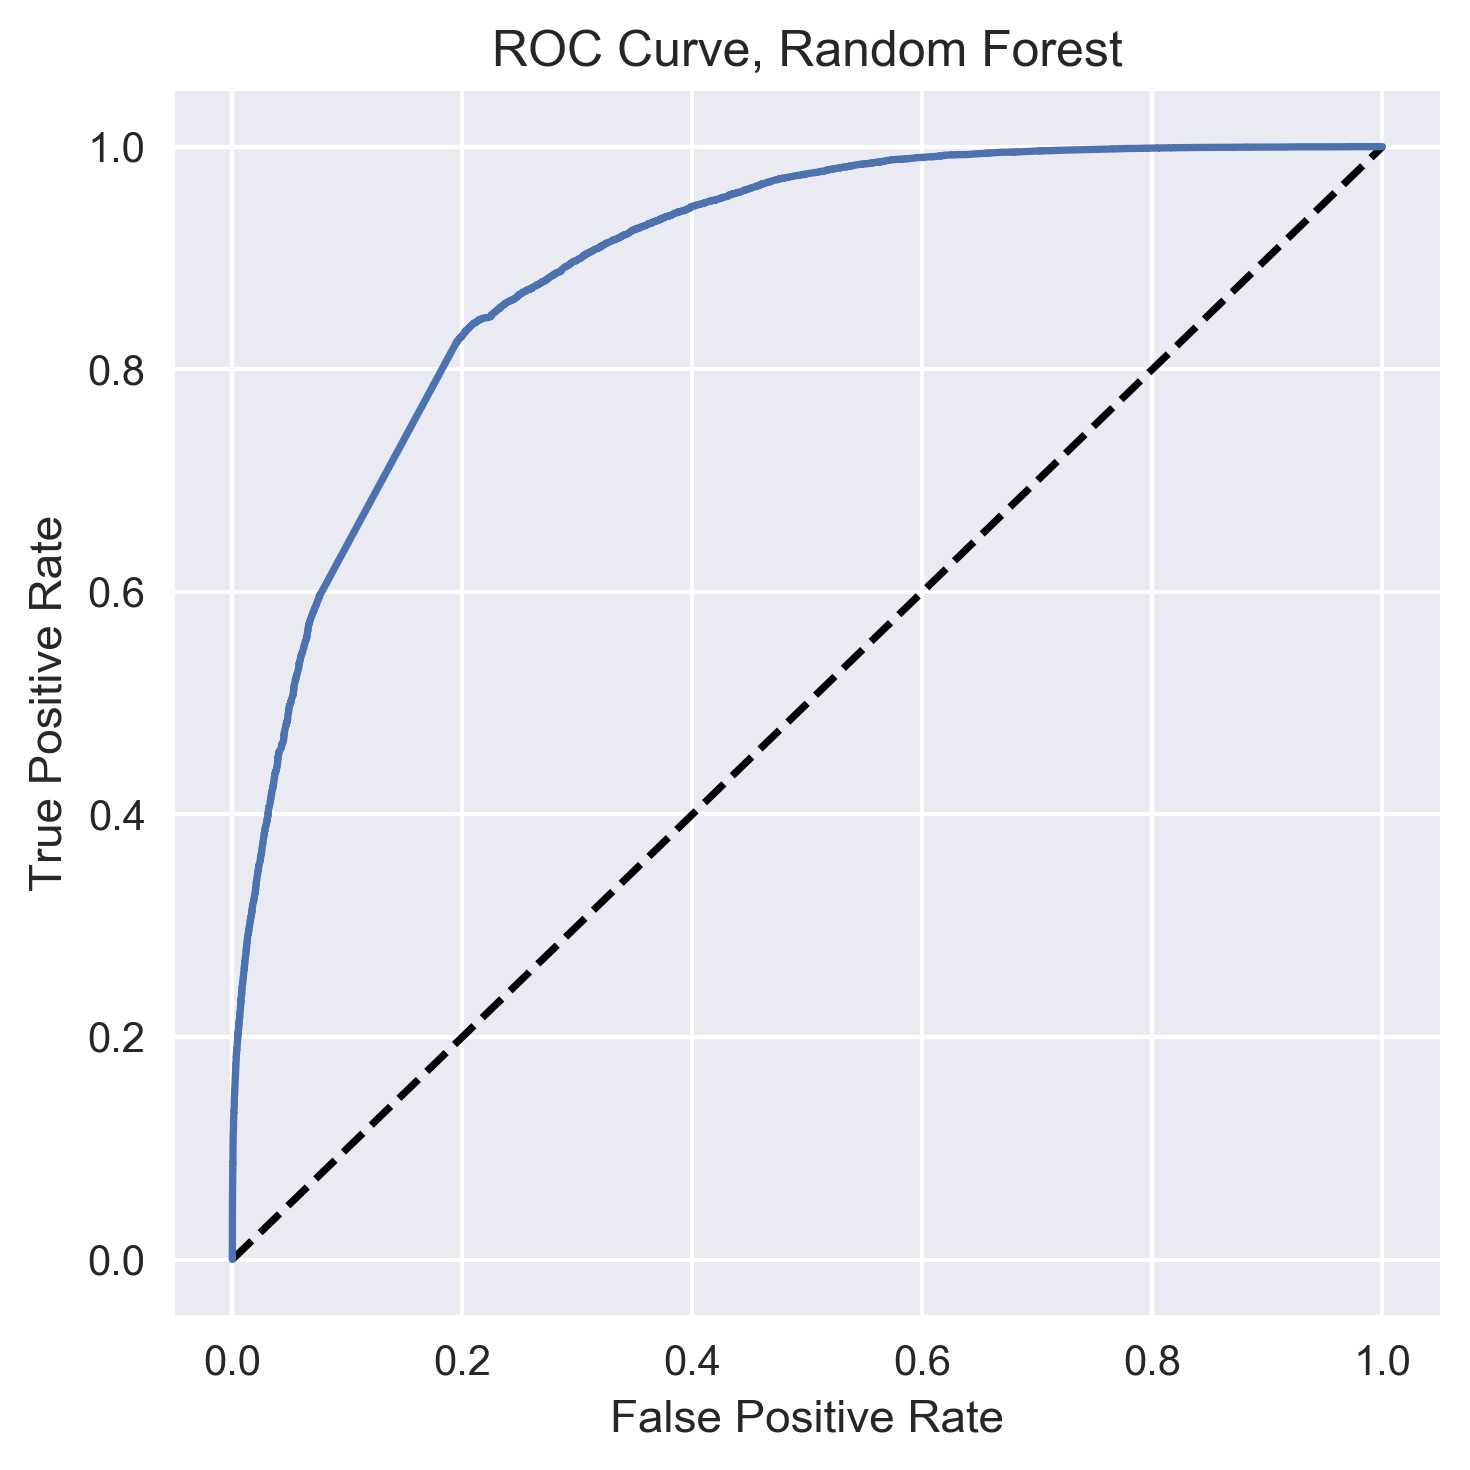

In [79]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=300, tight_layout=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Random Forest')
plt.show()
fig.savefig('../results/roc_curve_random_forest.png', dpi=fig.dpi)

### Gradient Boosting

In [52]:
# Setup a hyperparameter grid for gradient boosting
n_estimators = [100, 200, 500]
max_depth = [10, 50, 100]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

In [53]:
gboost = GradientBoostingClassifier(verbose=0.1)

In [54]:
gboost_cv = GridSearchCV(gboost, param_grid, cv=5, scoring='roc_auc')
gboost_cv.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3703          114.54m
         2           1.3579          114.99m
         3           1.3468          113.84m
         4           1.3376          112.27m
         5           1.3290          110.79m
         6           1.3210          109.27m
         7           1.3143          108.19m
         8           1.3066          106.82m
         9           1.3000          106.02m
        10           1.2944          104.77m
        20           1.2462           90.82m
        30           1.2111          107.31m
        40           1.1842           85.24m
        50           1.1607           68.18m
        60           1.1412           53.00m
        70           1.1227           38.59m
        80           1.1064           25.30m
        90           1.0924           12.53m
       100           1.0783            0.00s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [80]:
best_param_gboost = gboost_cv.best_params_
validation_auc_gboost = gboost_cv.best_score_
y_pred = gboost_cv.predict(X_test)
y_pred_prob = gboost_cv.predict_proba(X_test)[:, 1]
test_auc_gboost = roc_auc_score(y_test, y_pred_prob)
fpr_gboost, tpr_gboost, thresholds_gboost = roc_curve(y_test, y_pred_prob)

In [81]:
gboost_cv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [82]:
print('Tuned Gradient Boosting Parameters: {}'.format(best_param_gboost))
print('Tuned Gradient Boosting Validation AUC: {}'.format(validation_auc_gboost))
print('Tuned Gradient Boosting Test AUC: {}'.format(test_auc_gboost))

Tuned Gradient Boosting Parameters: {'max_depth': 10, 'n_estimators': 100}
Tuned Gradient Boosting Validation AUC: 0.8420832013228046
Tuned Gradient Boosting Test AUC: 0.8437934256298465


In [83]:
print(confusion_matrix(y_test, y_pred))

[[47966 33397]
 [ 4138 71634]]


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.59      0.72     81363
           1       0.68      0.95      0.79     75772

    accuracy                           0.76    157135
   macro avg       0.80      0.77      0.76    157135
weighted avg       0.81      0.76      0.75    157135



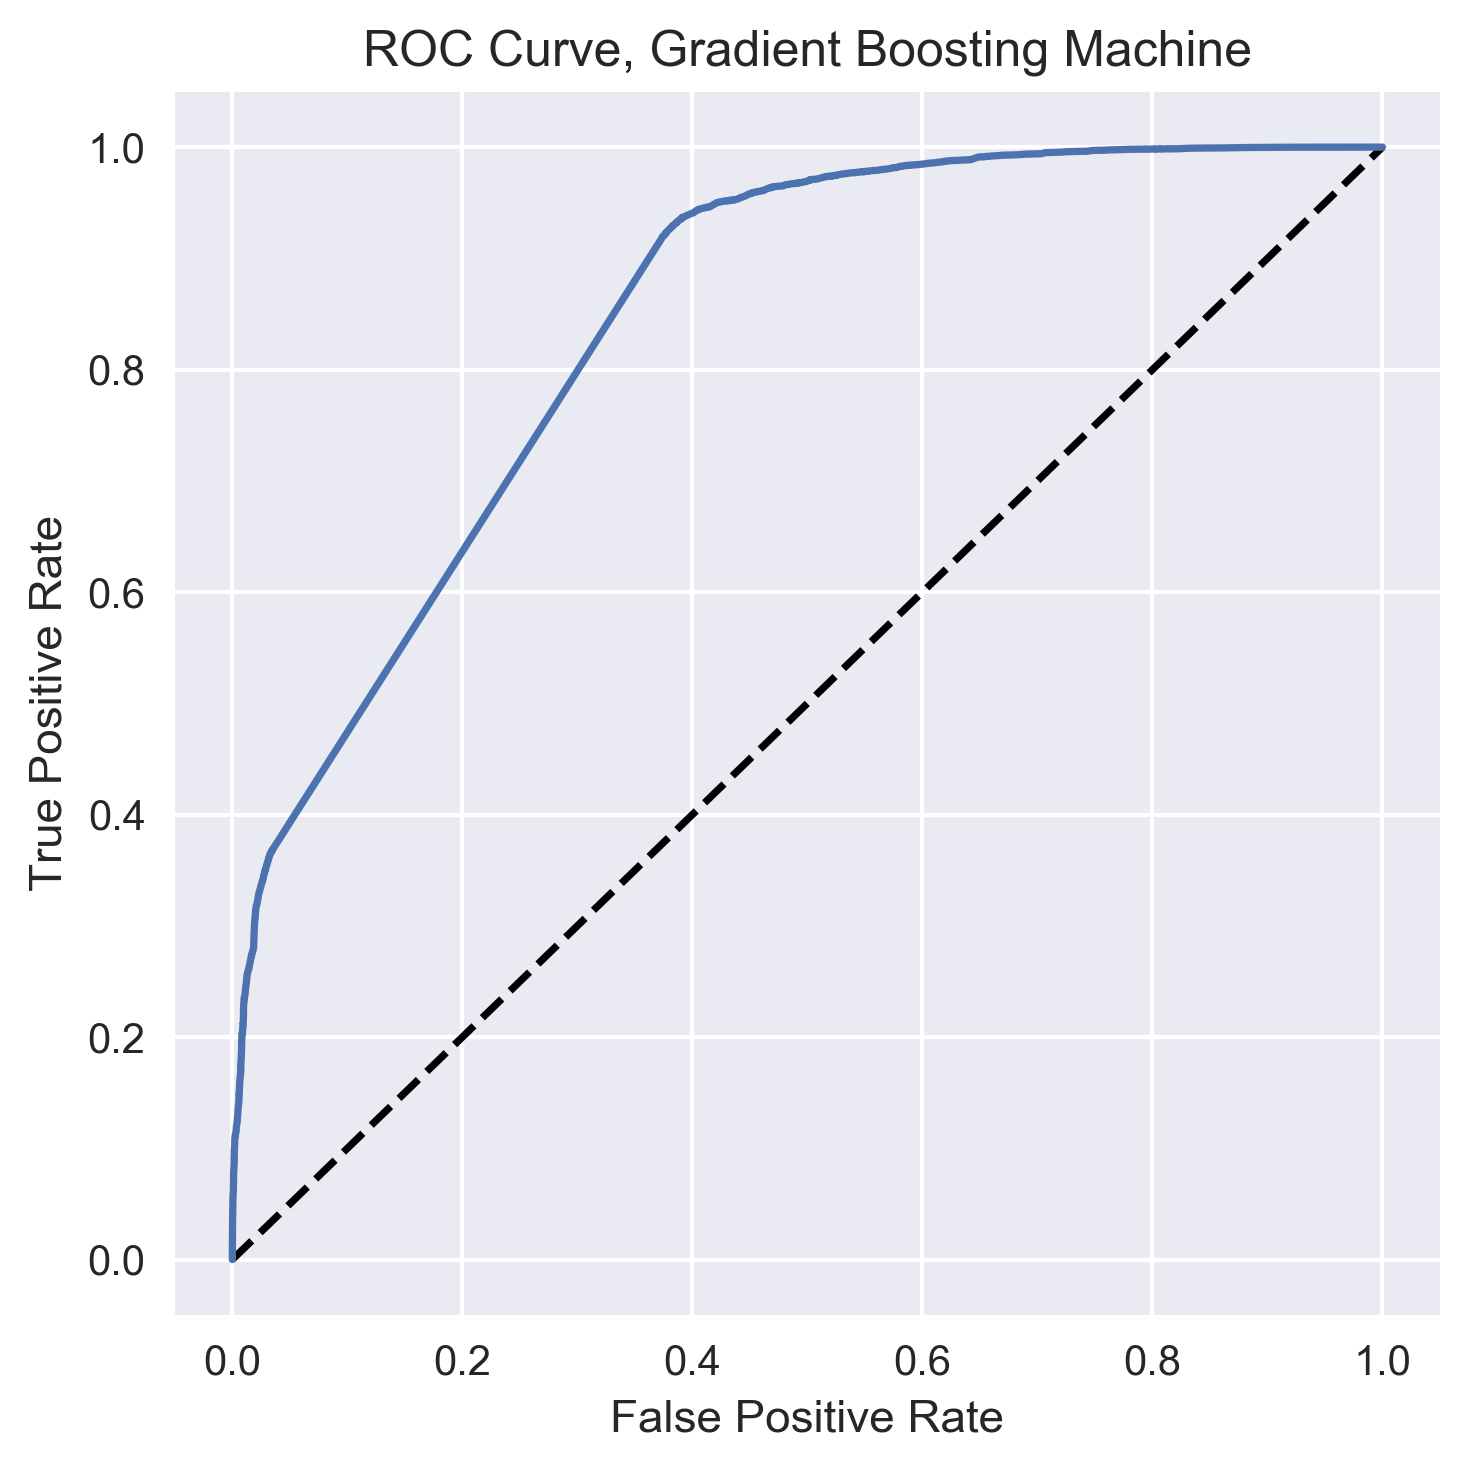

In [85]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=300, tight_layout=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gboost, tpr_gboost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Gradient Boosting Machine')
plt.show()
fig.savefig('../results/roc_curve_gradient_boosting.png', dpi=fig.dpi)